,festival_name,year,start_date,end_date
0,Amazon Great Indian Festival,2015,2015-01-10,2015-10-05
1,Amazon Great Indian Festival,2016,2016-01-10,2016-10-05
2,Amazon Great Indian Festival,2017,2017-01-10,2017-10-05
3,Amazon Great Indian Festival,2018,2018-01-10,2018-10-05
4,Amazon Great Indian Festival,2019,2019-01-10,2019-10-05


Festival rows: (621843, 38)


window,festival_tag,After,Before,During,Festival Lift (%)
2,Diwali Sale,"3,447,176,868.99","16,294,372.03","3,933,054,865.00","24,037.51"
6,Summer Sale,"955,862,454.35","661,438,532.62","2,105,477,877.39",218.32
1,Back to School,"642,652,290.13",0.00,"4,047,776,114.56",0.00
0,Amazon Great Indian Festival,"2,194,143,178.84",0.00,"2,506,235,659.14",0.00
3,Holi Festival,0.00,0.00,"1,874,989,476.82",0.00
5,Republic Day Sale,0.00,"2,575,576,661.66","955,085,887.85",-62.92
7,Valentine Sale,"3,151,569,635.13","2,429,627,304.14","660,653,058.12",-72.81
4,Prime Day,"3,203,891,704.99","2,053,319,484.86","432,588,189.84",-78.93


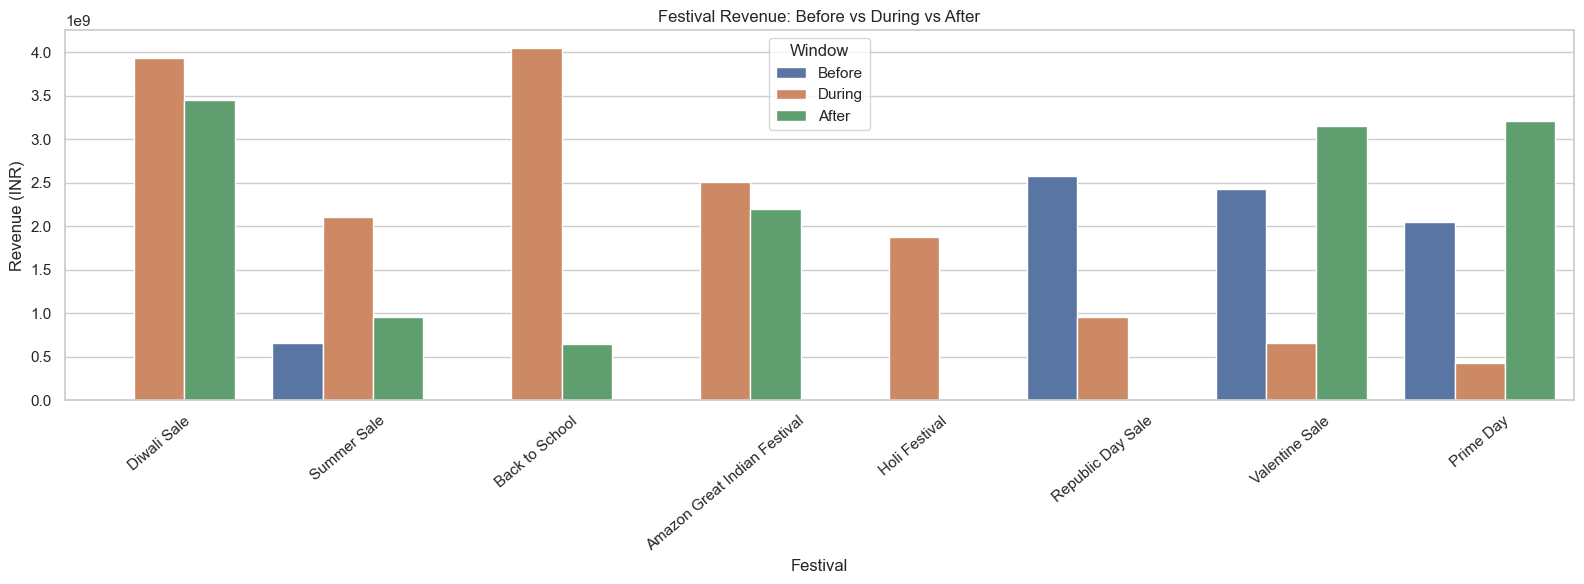

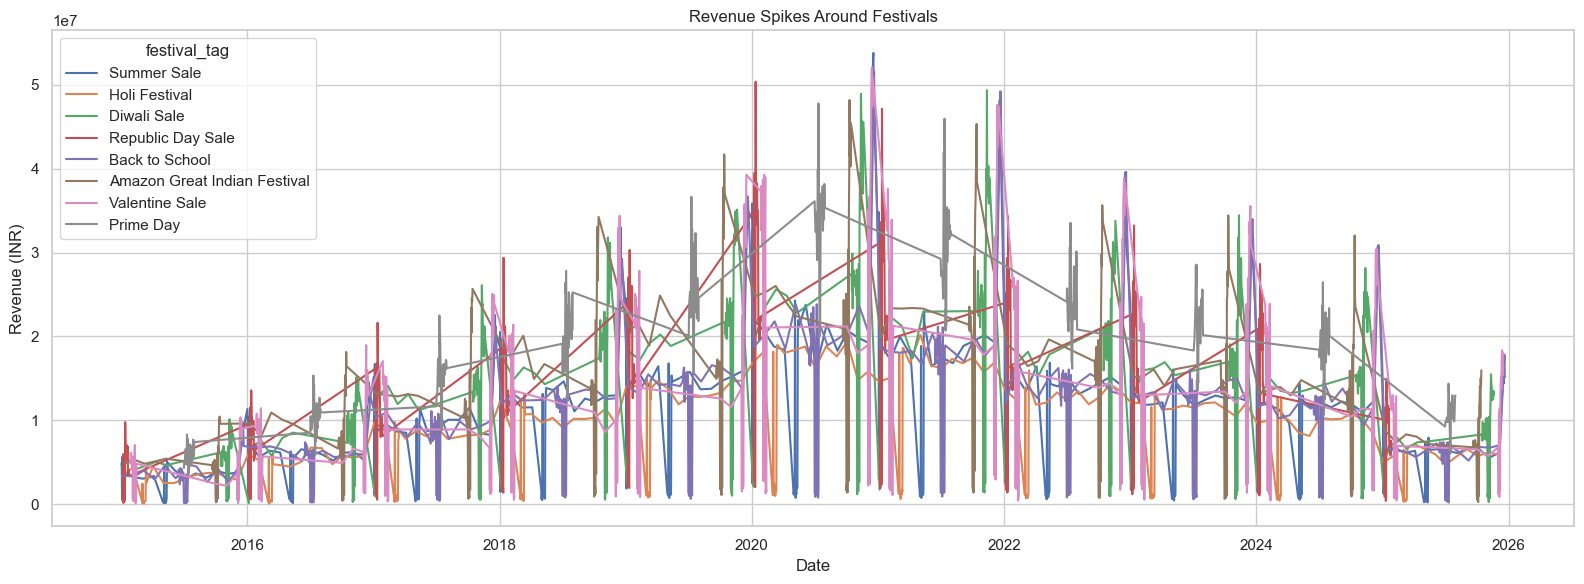

✅ EDA_07 COMPLETED USING DATA PERIODS


In [1]:
# ============================================================
# EDA_07 : FESTIVAL SALES IMPACT (DATA-DRIVEN)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid")

# ============================================================
# LOAD DATA
# ============================================================

df = pd.read_csv("../master/amazon_india_master_2015_2025.csv")

df["order_date"] = pd.to_datetime(df["order_date"])
df["year"] = df["order_date"].dt.year
df["revenue"] = df["final_amount_inr"]

# force string columns
df["window"] = pd.Series(index=df.index, dtype="object")
df["festival_tag"] = pd.Series(index=df.index, dtype="object")

# ============================================================
# BUILD FESTIVAL RANGES FROM DATA
# ============================================================

festival_ranges = (
    df[df["is_festival_sale"] == True]
    .groupby(["festival_name", "year"])
    .agg(
        start_date=("order_date", "min"),
        end_date=("order_date", "max")
    )
    .reset_index()
)

display(festival_ranges.head())

# ============================================================
# TAG BEFORE / DURING / AFTER
# ============================================================

BUFFER_DAYS = 14   # 2 weeks before & after

for _, row in festival_ranges.iterrows():

    mask_year = df["year"] == row["year"]

    mask_before = (
        mask_year &
        (df["order_date"] >= row["start_date"] - pd.Timedelta(days=BUFFER_DAYS)) &
        (df["order_date"] < row["start_date"]) &
        (df["is_festival_sale"] == False)
    )

    mask_during = (
        mask_year &
        (df["order_date"] >= row["start_date"]) &
        (df["order_date"] <= row["end_date"]) &
        (df["festival_name"] == row["festival_name"])
    )

    mask_after = (
        mask_year &
        (df["order_date"] > row["end_date"]) &
        (df["order_date"] <= row["end_date"] + pd.Timedelta(days=BUFFER_DAYS)) &
        (df["is_festival_sale"] == False)
    )

    df.loc[mask_before, "window"] = "Before"
    df.loc[mask_during, "window"] = "During"
    df.loc[mask_after, "window"] = "After"

    df.loc[
        mask_before | mask_during | mask_after,
        "festival_tag"
    ] = row["festival_name"]

festival_df = df[df["festival_tag"].notna()].copy()

print("Festival rows:", festival_df.shape)

# ============================================================
# AGGREGATE REVENUE
# ============================================================

festival_revenue = (
    festival_df
    .groupby(["festival_tag", "window"], as_index=False)
    .agg(
        total_revenue=("revenue", "sum"),
        orders=("transaction_id", "count")
    )
)

# ============================================================
# SUMMARY TABLE
# ============================================================

festival_summary = (
    festival_revenue
    .pivot_table(
        index="festival_tag",
        columns="window",
        values="total_revenue",
        fill_value=0
    )
    .reset_index()
)

for c in ["Before", "During", "After"]:
    if c not in festival_summary.columns:
        festival_summary[c] = 0

festival_summary["Festival Lift (%)"] = np.where(
    festival_summary["Before"] > 0,
    ((festival_summary["During"] - festival_summary["Before"])
     / festival_summary["Before"]) * 100,
    0
)

festival_summary = festival_summary.sort_values(
    "Festival Lift (%)",
    ascending=False
)

display(festival_summary)

# ============================================================
# BAR CHART
# ============================================================

melted = festival_summary.melt(
    id_vars="festival_tag",
    value_vars=["Before", "During", "After"],
    var_name="Window",
    value_name="Revenue"
)

plt.figure(figsize=(16, 6))
sns.barplot(data=melted, x="festival_tag", y="Revenue", hue="Window")
plt.xticks(rotation=40)
plt.title("Festival Revenue: Before vs During vs After")
plt.ylabel("Revenue (INR)")
plt.xlabel("Festival")
plt.tight_layout()
plt.show()

# ============================================================
# TIME SERIES SPIKES
# ============================================================

daily = (
    festival_df
    .groupby(["order_date", "festival_tag"], as_index=False)
    .agg(revenue=("revenue", "sum"))
)

plt.figure(figsize=(16, 6))
sns.lineplot(
    data=daily,
    x="order_date",
    y="revenue",
    hue="festival_tag"
)

plt.title("Revenue Spikes Around Festivals")
plt.ylabel("Revenue (INR)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

print("✅ EDA_07 COMPLETED USING DATA PERIODS")
